# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

def plot(*args):
    count = len(args)
    fig, ax = plt.subplots(1,count)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    if count==1:
        ax.imshow(args[0], cmap="gray")
    else:
        for i in range(len(ax)):
            ax[i].imshow(args[i], cmap="gray")
    plt.show()

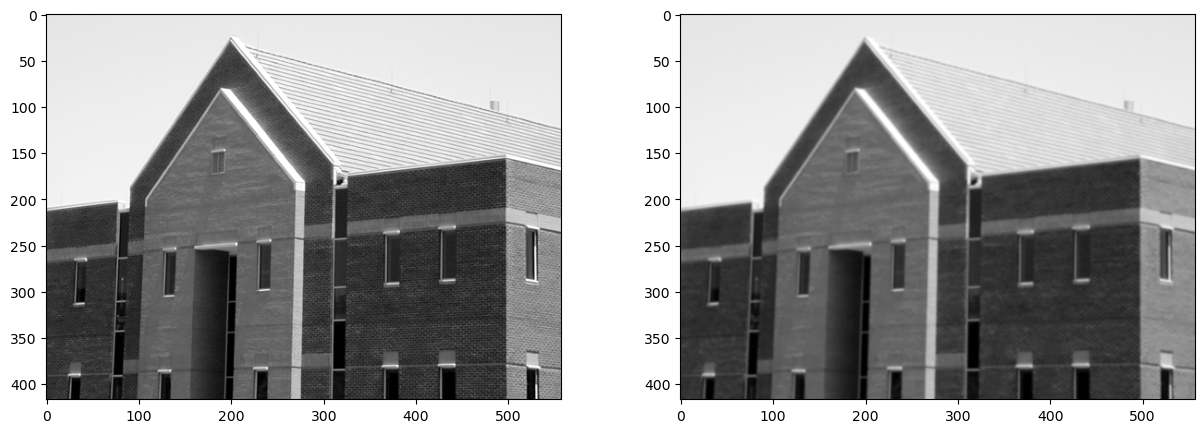

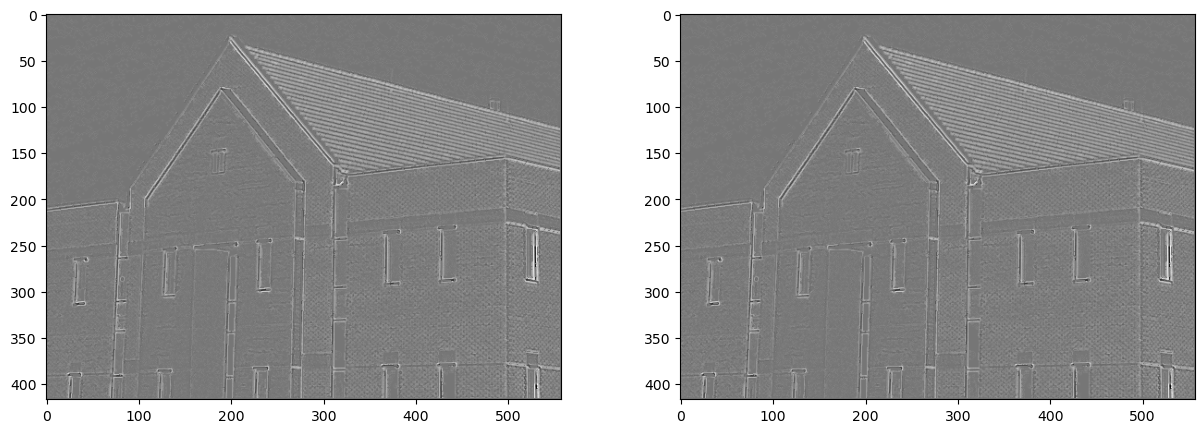

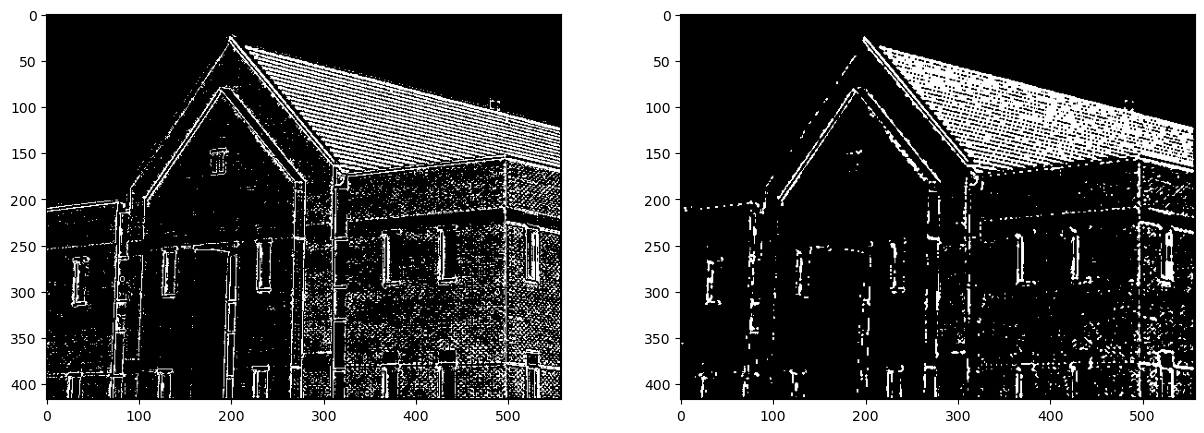

In [2]:
image = cv2.imread('dom.png',cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5,5), 1)
plot(image, blurred)
laplas = cv2.Laplacian(blurred, cv2.CV_32F)

def crossing(gaus, threshold, lap_image):
#     print(lap_image.shape)
    (x,y) = lap_image.shape
    new_image = np.zeros(lap_image.shape)
    new_image = new_image.astype("float32")
    for i in range(1, x-1):
        for j in range(1, y-1):
            context = lap_image[i-1:i+2,j-1:j+2]
            min_val, max_val = np.min(context), np.max(context)
            if(min_val*max_val)<0:
                if(lap_image[i,j]>0):
                    new_image[i,j]=lap_image[i,j]+abs(min_val)
                if(lap_image[i,j]<0):
                    new_image[i,j]=lap_image[i,j]+abs(max_val)
                    
    normalized_res=np.zeros(new_image.shape,"uint8")
    normalized_res = cv2.normalize(new_image,normalized_res,0,255,cv2.NORM_MINMAX)
    plot(new_image,normalized_res)
    
    bin_image = new_image>threshold
    bin_image = bin_image.astype("uint8")

    
    blurred_res = cv2.medianBlur(bin_image, 3)
    plot(bin_image, blurred_res)
    
crossing(1,10, laplas)
# plot(laplas)
# print(laplas)

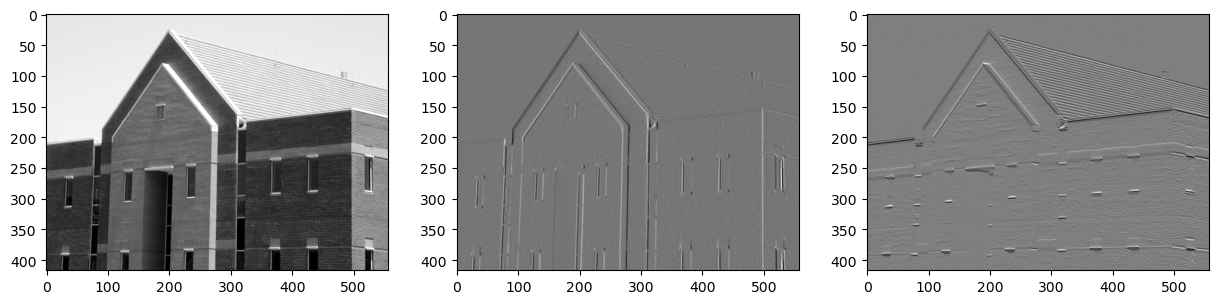

(417, 557) (417, 557) (417, 557)


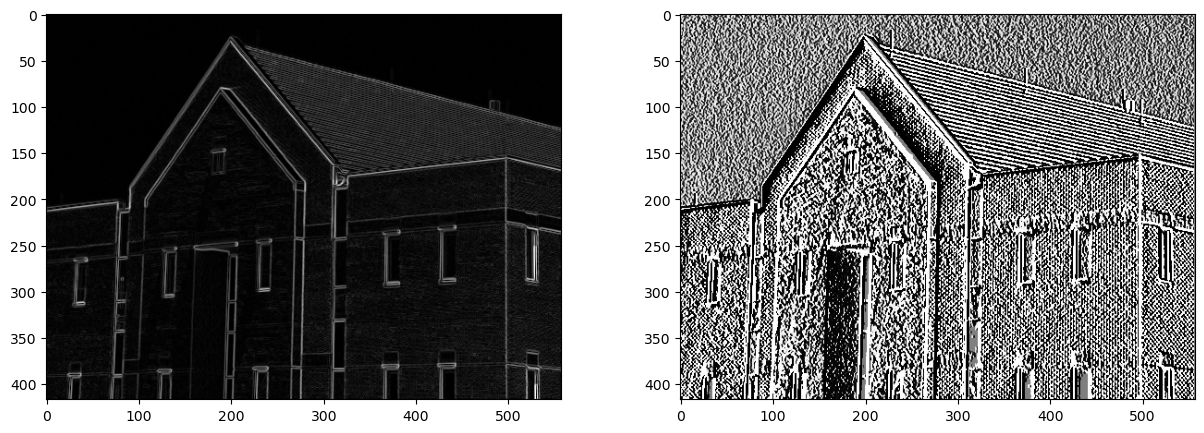

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [28]:
import math
image = cv2.imread(f'dom.png',cv2.IMREAD_GRAYSCALE).astype("float32")
s1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
s2 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])


image_s1 = cv2.filter2D(src=image, ddepth=-1, kernel=s1)
image_s2 = cv2.filter2D(src=image, ddepth=-1, kernel=s2)

plot(image, image_s1, image_s2)
print(image.shape, image_s1.shape, image_s2.shape)

m_image = np.sqrt(image_s1**2+image_s2**2)
a_image = np.arctan(image_s1, image_s2)
plot(m_image, a_image)
i,j=234,223
# print(m_image[i,j], image_s1[i,j], image_s2[i,j] )
def nomax(m_image,a_image):
    x, y = image.shape
    res = np.zeros((x-1, y-1))
    
    for i in range(1, x-1):
        for j in range(1, y-1):
            degrees = math.degrees(a_image[i,j])
            
            #poziomy
            if degrees>=22.5 and degrees<=22.5:
                pass
            
            #prawy skos
            if degrees >22.5 and degrees <=67.5:
                pass
            
            #pion
            if degrees>67.5 and degrees <=112.5:
                pass
            
            #lewy skos
            if degrees>112.5 and degrees<=157.5:
                
                pass
            print(degrees if degrees>90 else None)
            
nomax(m_image, a_image)






## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.